### 读取数据 创建字典索引

In [384]:
from collections import defaultdict 

aid_to_name = defaultdict(list) 
ait_to_picture = defaultdict(list) 
aname_to_id = defaultdict(list) 
tid_to_name = defaultdict(list) 
tname_to_id = defaultdict(list) 

with open('artists.dat', 'r', encoding='utf-8', errors='ignore') as f: 
    for line in f.readlines(): 
        line=line.strip('\n')
        try:
            artist_id,name,url,picture = line.split('\t')
        except ValueError: 
            print("Record: ", line)
            raise Exception("Failed while unpacking. Not enough arguments to supply.") 
        aid_to_name[artist_id]=name
        aname_to_id[name]=artist_id

with open('tags.dat', 'r', encoding='utf-8', errors='ignore') as f: 
    for line in f.readlines(): 
        line=line.strip('\n')
        try:
            tag_id,name = line.split('\t')
        except ValueError: 
            print("Record: ", line)
            raise Exception("Failed while unpacking. Not enough arguments to supply.") 
        tid_to_name[tag_id]=name
        tname_to_id[name]=tag_id
        

### 导入数据，标准化rating到1-100之间

In [368]:
import numpy as np
def rescale_linear(array):
    minimum, maximum = np.min(array), np.max(array)
    m = (100 - 1) / (maximum - minimum)
    b = 1 - m * minimum
    return m * array + b

array = np.array([1,4,11,5,7])
rescale_linear(array)

array([  1. ,  30.7, 100. ,  40.6,  60.4])

In [369]:
import pandas as pd
df = pd.read_csv("u_a.csv")
uid_list = df.uid.unique().tolist()
new_df = pd.DataFrame(columns=['uid', 'iid', 'weight'])

for uid in uid_list:
    iid_weight = df.loc[df['uid'] == uid, ['iid','weight']]
    iid_list = iid_weight['iid'].tolist()
    weight_list = iid_weight['weight'].tolist()
    new_weight_list = rescale_linear(np.array(weight_list))
    for i in range(0,len(iid_list)):
        new_df = new_df.append({'uid': uid, 'iid': iid_list[i], 'weight':new_weight_list[i]}, ignore_index=True)
    

/Users/faushine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.
/Users/faushine/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  


In [370]:
new_df['uid']=new_df['uid'].astype('object')
new_df['iid']=new_df['iid'].astype('int')
new_df['weight'] = new_df['weight'].values.astype(np.int64)
new_df.to_csv('new_weight.dat', index=False, sep='\t', header=None)
new_df.head(5)

,uid,iid,weight
0,2,51,100
1,2,52,82
2,2,53,80
3,2,54,71
4,2,55,61


### 将数据导入dataset 定义user item 和rating

In [371]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import os
import io

from surprise import KNNBaseline, Reader
from surprise import Dataset
from surprise import GridSearch
from surprise import Dataset, print_perf
from surprise.model_selection import cross_validate

columns=['userID', 'itemID', 'rating']
df = pd.read_csv("new_weight.dat",header=None, sep='\t',names=columns)
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)


In [372]:
data.raw_ratings[100:103]

[(4.0, 51, 1.0, None), (4.0, 53, 11.0, None), (4.0, 64, 5.0, None)]

### 遍历模型，交叉验证

In [374]:
loss_result=[]
al_name = []

### 使用NormalPredictor
from surprise import NormalPredictor
algo = NormalPredictor()
np_perf = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3)
print_perf(np_perf)
loss_result.append(np_perf)
al_name.append('NormalPredictor')


### 使用BaselineOnly
from surprise import BaselineOnly
algo = BaselineOnly()
bo_perf = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3)
print_perf(bo_perf)
loss_result.append(bo_perf)
al_name.append('BaselineOnly')



### 使用基础版协同过滤
from surprise import KNNBasic, evaluate
algo = KNNBasic()
knnb_perf = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3)
print_perf(knnb_perf)
loss_result.append(knnb_perf)
al_name.append('KNNBasic')



### 使用均值协同过滤
from surprise import KNNWithMeans, evaluate
algo = KNNWithMeans()
knnm_perf = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3)
print_perf(knnm_perf)
loss_result.append(knnm_perf)
al_name.append('KNNWithMeans')


### 使用协同过滤baseline
from surprise import KNNBaseline, evaluate
algo = KNNBaseline()
knnb_perf = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3)
print_perf(knnb_perf)
loss_result.append(knnb_perf)
al_name.append('KNNBaseline')



### 使用SVD
from surprise import SVD, evaluate
algo = SVD()
svd_perf = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3)
print_perf(svd_perf)
loss_result.append(svd_perf)
al_name.append('SVD')



### 使用SVD++
from surprise import SVDpp, evaluate
algo = SVDpp()
svdpp_perf = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3)
print_perf(svdpp_perf)
loss_result.append(svdpp_perf)
al_name.append('SVDpp')



### 使用NMF
from surprise import NMF
algo = NMF()
nmf_perf = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3)
print_perf(nmf_perf)
loss_result.append(nmf_perf)
al_name.append('NMF')


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
        Fold 1  Fold 2  Fold 3  Mean    
TEST_RMSE181628964241856000.0000157295297096502720.0000165806480425477024.0000168243580587945248.0000
TEST_MAE3576683291073119.00002682512468304841.50002980665730627847.00003079953830001936.0000
FIT_TIME0.4402  0.4322  0.5013  0.4579  
TEST_TIME2.8737  2.8054  2.8738  2.8510  
        Fold 1  Fold 2  Fold 3  Mean    
TEST_RMSE117240992282935120.0000216181708113930528.0000157297838688189504.0000163573513028351712.0000
TEST_MAE1490284704613805.25005066967995686913.00002682599157565062.50003079950619288593.5000
FIT_TIME3.8659  3.8235  4.4931  4.0608  
TEST_TIME0.1770  0.1754  0.1811  0.1778  
        Fold 1  Fold 2  Fold 3  Mean    
TEST_RMSE

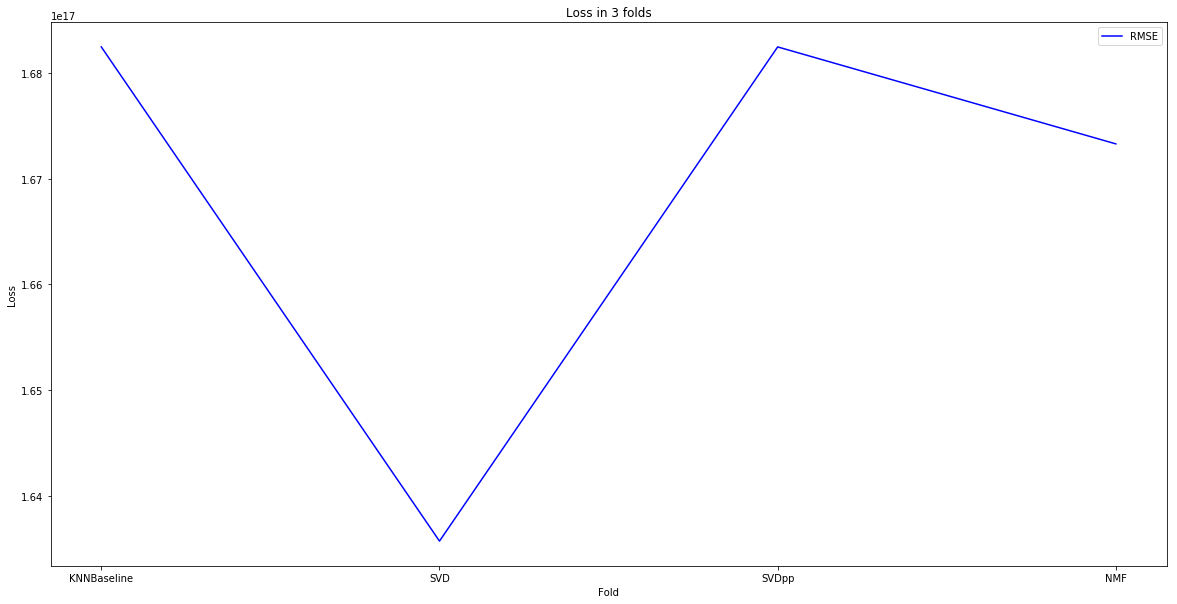

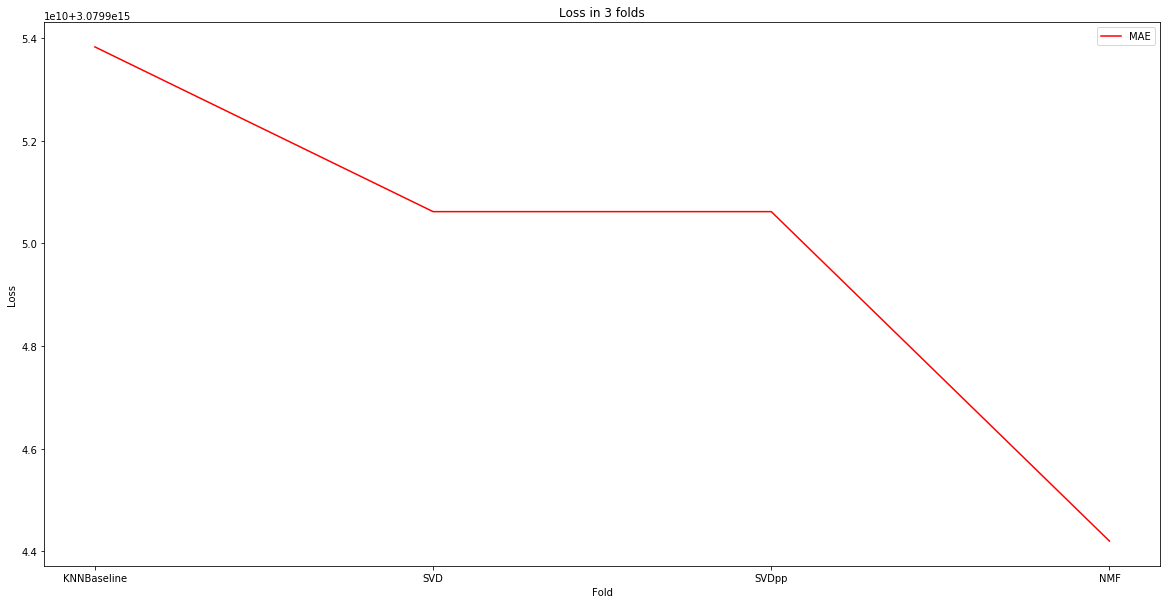

In [375]:
import matplotlib.pyplot as plt
from statistics import mean

test_rmse = []
test_mae = []
for item in loss_result:
    test_rmse.append(mean(item['test_rmse']))
    test_mae.append(mean(item['test_mae']))
    

fig1, ax = plt.subplots(figsize=(20,10))
ax.plot(al_name,test_rmse, 'blue', label='RMSE') 
ax.set_xlabel('Fold')
ax.set_ylabel('Loss')
ax.set_title('Loss in 3 folds')
plt.legend()

fig2, bx = plt.subplots(figsize=(20,10))
bx.plot(al_name,test_mae, 'red', label='MAE')
bx.set_xlabel('Fold')
bx.set_ylabel('Loss')
bx.set_title('Loss in 3 folds')
plt.legend()


### 用损失最小的模型做预测

#### 用KNNBasic建模预测, 对每个user推荐N个artist

In [376]:
from collections import defaultdict

from surprise import KNNBasic


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
sim_options = {'name': 'cosine','user_based': True}
algo = KNNBasic()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Computing the msd similarity matrix...
Done computing similarity matrix.
2.0 [101, 103, 107, 113, 126, 132, 137, 141, 151, 152]
3.0 [51, 53, 55, 56, 57, 58, 64, 65, 67, 69]
4.0 [55, 56, 58, 62, 66, 67, 68, 69, 71, 73]
5.0 [51, 54, 55, 56, 57, 58, 59, 62, 63, 64]
6.0 [51, 52, 53, 54, 55, 57, 58, 59, 60, 61]
7.0 [51, 54, 56, 57, 58, 59, 60, 62, 63, 64]
8.0 [51, 52, 53, 54, 55, 58, 59, 60, 61, 62]
9.0 [51, 52, 53, 55, 56, 57, 58, 63, 64, 65]
10.0 [51, 55, 56, 57, 58, 59, 61, 64, 65, 66]
11.0 [51, 53, 56, 57, 62, 63, 65, 68, 69, 71]
12.0 [51, 53, 54, 55, 56, 58, 59, 62, 63, 64]
13.0 [51, 54, 56, 57, 58, 60, 62, 63, 64, 65]
14.0 [51, 53, 55, 56, 58, 61, 63, 64, 65, 66]
15.0 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
16.0 [51, 52, 53, 54, 55, 56, 57, 59, 60, 62]
17.0 [51, 53, 54, 55, 57, 58, 59, 60, 61, 62]
18.0 [51, 53, 54, 55, 57, 58, 59, 60, 61, 62]
20.0 [51, 53, 54, 55, 57, 58, 60, 62, 63, 65]
21.0 [51, 54, 56, 57, 58, 59, 60, 62, 63, 64]
22.0 [51, 52, 53, 56, 59, 63, 65, 67, 69, 70]
23.0 

1305.0 [51, 53, 56, 57, 58, 62, 63, 64, 65, 66]
1307.0 [51, 52, 53, 54, 56, 57, 58, 59, 60, 61]
1308.0 [51, 53, 56, 58, 59, 60, 63, 64, 68, 69]
1309.0 [51, 52, 53, 54, 55, 56, 57, 58, 59, 62]
1310.0 [51, 53, 54, 55, 56, 58, 63, 64, 65, 66]
1311.0 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
1312.0 [51, 55, 56, 57, 59, 62, 63, 64, 65, 67]
1313.0 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
1315.0 [51, 67, 70, 77, 80, 89, 138, 157, 163, 192]
1316.0 [51, 53, 55, 56, 57, 58, 59, 60, 62, 63]
1318.0 [51, 53, 54, 55, 56, 57, 58, 59, 62, 64]
1319.0 [51, 52, 53, 54, 55, 56, 57, 59, 61, 62]
1321.0 [51, 53, 54, 55, 57, 58, 61, 62, 63, 64]
1322.0 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
1323.0 [51, 53, 55, 56, 57, 58, 59, 61, 62, 63]
1324.0 [51, 52, 53, 54, 55, 56, 57, 58, 59, 62]
1325.0 [51, 53, 54, 55, 56, 57, 59, 63, 64, 65]
1327.0 [52, 53, 55, 56, 57, 58, 60, 62, 64, 65]
1329.0 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
1330.0 [51, 52, 53, 55, 56, 57, 59, 64, 65, 67]
1331.0 [51, 52, 55, 56, 57, 58, 59, 

#### 比较artist之间相似度，找到最相似的10个邻居

In [393]:
# 用KNNBaseline建模预测, get the top-N recommendations for an item
# 计算ARTIST和ARTIST之间的相似度
trainset = data.build_full_trainset()
sim_options = {'name': 'cosine','user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [437]:
# 根据item做预测
itemid = int(aname_to_id['Coldplay'])
item_innerid = algo.trainset.to_inner_iid(itemid)
# 找到最近的10个邻居
item_neighbors = algo.get_neighbors(item_innerid, k=10)
item_neighbors

[9, 23, 27, 28, 31, 32, 36, 41, 43, 62]

In [439]:
# 从近邻的id映射回artist名称
item_rids = []
item_names=[]

for inner_id in item_neighbors:
    a = algo.trainset.to_raw_iid(inner_id)
    item_rids.append(a)                        

for rid in item_rids:
    a = rid_to_name[str(rid)]
    item_names.append(a)

print()
print('The 10 nearest neighbors of Coldplay are:')
for artist in item_names:
    print(artist)


The 10 nearest neighbors of Coldplay are:
Three Colors: Blue (1993)
Faster Pussycat! Kill! Kill! (1965)
Free Willy (1993)
Fugitive, The (1993)
Jurassic Park (1993)
Much Ado About Nothing (1993)
Searching for Bobby Fischer (1993)
True Romance (1993)
Home Alone (1990)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995)


### 不用看

In [423]:
# 根据user做预测
# 设置超参数搜索
param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [2, 3],
              'sim_options': {'name': ['msd', 'cosine'],
                              'min_support': [1, 5],
                              'user_based': [True]}
              }
# KNNWithMeans 基于的一个假设也是用户和item的评分有高低，去除一个平均值后再计算。 KNNBaseline基于KNNWithMeans，将均值换成baseline的值
# 使用网格搜索交叉验证
grid_search = GridSearch(KNNBaseline, param_grid, measures=['RMSE', 'FCP'])
# 在数据集上找到最好的参数
grid_search.evaluate(data)

/Users/faushine/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:232: UserWarning: The GridSearch() class is deprecated. Please use model_selection.GridSearchCV instead.
  'model_selection.GridSearchCV instead.', UserWarning)
/Users/faushine/anaconda3/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/Users/faushine/anaconda3/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Running grid search for the following parameter combinations:
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 2, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 2, 'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 2, 'sim_options': {'name': 'cosine', 'min_support': 1, 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 2, 'sim_options': {'name': 'cosine', 'min_support': 5, 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 3, 'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 3, 'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 3, 'sim_options': {'name': 'cosine', 'min_support': 1, 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 3, 'sim_options': 

KeyboardInterrupt: 